Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [6]:
# These are all the modules we'll be using later. Make sure you can import them before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import gcp
import gcp.storage as storage

sample_bucket_name = gcp.Context.default().project_id + '-datalab' + '/notMNIST/'
sample_bucket_path = 'gs://' + sample_bucket_name
sample_bucket_object = sample_bucket_path + 'notMNIST.pickle'

In [3]:
%storage read --object $sample_bucket_object --variable data

In [2]:
save = pickle.loads(data)
del data
train_dataset = save['train_dataset']
train_labels = save['train_labels']
valid_dataset = save['valid_dataset']
valid_labels = save['valid_labels']
test_dataset = save['test_dataset']
test_labels = save['test_labels']
del save  # hint to help gc free up memory
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

NameError: name 'data' is not defined

In [7]:
mainRoot = '/home/christophe/data/'
mainRoot = ''
pickle_file = mainRoot + 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

Initialized
Minibatch loss at step 0: 3.617367
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.743474
Minibatch accuracy: 56.2%
Validation accuracy: 42.5%
Minibatch loss at step 100: 0.976794
Minibatch accuracy: 75.0%
Validation accuracy: 68.1%
Minibatch loss at step 150: 1.000817
Minibatch accuracy: 75.0%
Validation accuracy: 75.1%
Minibatch loss at step 200: 1.349190
Minibatch accuracy: 56.2%
Validation accuracy: 75.4%
Minibatch loss at step 250: 0.354620
Minibatch accuracy: 87.5%
Validation accuracy: 78.5%
Minibatch loss at step 300: 0.065487
Minibatch accuracy: 100.0%
Validation accuracy: 78.6%
Minibatch loss at step 350: 0.671826
Minibatch accuracy: 93.8%
Validation accuracy: 80.7%
Minibatch loss at step 400: 0.869650
Minibatch accuracy: 62.5%
Validation accuracy: 81.3%
Minibatch loss at step 450: 1.059122
Minibatch accuracy: 68.8%
Validation accuracy: 81.5%
Minibatch loss at step 500: 0.103868
Minibatch accuracy: 100.0%
Validation accuracy: 81.9%

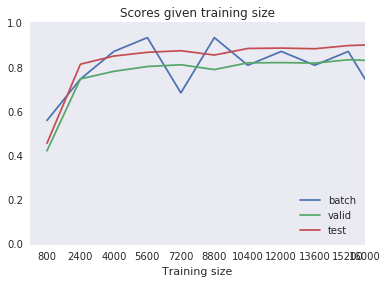

In [7]:
# Version with Conv > ReLU > Conv > ReLU > FullyConnected > ReLU > FullyConnected

batch_size = 16
#batch_size = 4
patch_size = 5
depth = 16
num_hidden = 64
#num_hidden = 8

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases

    # Training computation.
    logits = model(tf_train_dataset)
    #with tf.name_scope('accuracy'):
        #tf.scalar_summary('logitsej', logits) # TensorBOARD
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))


# To visualize generated data in TensorBoard :
# 1/ In a (tensorflow env)-terminal run : tensorboard --logdir=//home/christophe/data/tensorboard
# 2/ Browse to : http://localhost:6006

num_steps = 1001

data = np.ndarray(shape=(1+num_steps//100,4), dtype=np.float32)

with tf.Session(graph=graph) as session:

    #merged = tf.merge_all_summaries() # TensorBOARD
    #train_writer = tf.train.SummaryWriter('/home/christophe/data/tensorboard', session.graph) # TensorBOARD

    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            #session.run([merged], feed_dict=feed_dict(False))
            #session.run([merged])
            batch_score = accuracy(predictions, batch_labels)
            valid_score = accuracy(valid_prediction.eval(), valid_labels)
            test_score = accuracy(test_prediction.eval(), test_labels)
            data[step//100,:] = [step*batch_size, batch_score/100, valid_score/100, test_score/100]
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % batch_score)
            print("Validation accuracy: %.1f%%" % valid_score)
    print("Test accuracy: %.1f%%" % test_score)

fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1:4])
ax.set_title('Scores given training size')
ax.legend(('batch','valid', 'test'), loc='lower right')
ax.set_xticks(data[:,0])
ax.set_xlabel('Training size')
ax.set_ylim(0,1.01)
ax.grid()

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

Initialized
Minibatch loss at step 0: 2.662959
Minibatch accuracy: 31.2%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.771421
Minibatch accuracy: 43.8%
Validation accuracy: 49.8%
Minibatch loss at step 100: 1.073999
Minibatch accuracy: 62.5%
Validation accuracy: 65.1%
Minibatch loss at step 150: 0.991686
Minibatch accuracy: 75.0%
Validation accuracy: 76.5%
Minibatch loss at step 200: 1.696322
Minibatch accuracy: 62.5%
Validation accuracy: 70.0%
Minibatch loss at step 250: 0.408689
Minibatch accuracy: 87.5%
Validation accuracy: 80.0%
Minibatch loss at step 300: 0.105627
Minibatch accuracy: 100.0%
Validation accuracy: 79.7%
Minibatch loss at step 350: 0.502244
Minibatch accuracy: 87.5%
Validation accuracy: 82.1%
Minibatch loss at step 400: 0.656441
Minibatch accuracy: 75.0%
Validation accuracy: 82.0%
Minibatch loss at step 450: 0.983512
Minibatch accuracy: 75.0%
Validation accuracy: 82.7%
Minibatch loss at step 500: 0.087240
Minibatch accuracy: 100.0%
Validation accuracy: 82.5%

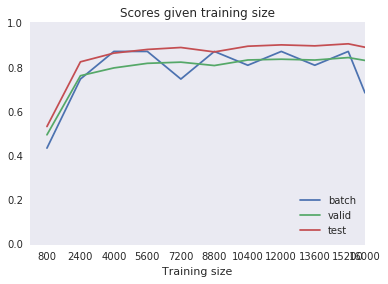

In [5]:
# Version with Conv > MaxPool > ReLU > Conv > MaxPool > ReLU > FullyConnected > ReLU > FullyConnected

batch_size = 16
#batch_size = 4
patch_size = 5
depth = 16
num_hidden = 64
#num_hidden = 8

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    # Model.
    def model(data):
        # Conv > MaxPool > ReLU
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(hidden + layer1_biases)

        # Conv > MaxPool > ReLU
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(hidden + layer2_biases)

        # Reshape cube to line
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])

        # Fully Connected > ReLU > Fully Connected
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases

    # Training computation.
    logits = model(tf_train_dataset)
    #with tf.name_scope('accuracy'):
        #tf.scalar_summary('logitsej', logits) # TensorBOARD
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))



# To visualize generated data in TensorBoard :
# 1/ In a (tensorflow env)-terminal run : tensorboard --logdir=//home/christophe/data/tensorboard
# 2/ Browse to : http://localhost:6006

num_steps = 1001

data = np.ndarray(shape=(1+num_steps//100,4), dtype=np.float32)

with tf.Session(graph=graph) as session:

    #merged = tf.merge_all_summaries() # TensorBOARD
    #train_writer = tf.train.SummaryWriter('/home/christophe/data/tensorboard', session.graph) # TensorBOARD

    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            #session.run([merged], feed_dict=feed_dict(False))
            #session.run([merged])
            batch_score = accuracy(predictions, batch_labels)
            valid_score = accuracy(valid_prediction.eval(), valid_labels)
            test_score = accuracy(test_prediction.eval(), test_labels)
            data[step//100,:] = [step*batch_size, batch_score/100, valid_score/100, test_score/100]
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % batch_score)
            print("Validation accuracy: %.1f%%" % valid_score)
    print("Test accuracy: %.1f%%" % test_score)

fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1:4])
ax.set_title('Scores given training size')
ax.legend(('batch','valid', 'test'), loc='lower right')
ax.set_xticks(data[:,0])
ax.set_xlabel('Training size')
ax.set_ylim(0,1.01)
ax.grid()

Initialized
Minibatch loss at step 0: 5.195992
Minibatch accuracy: 0.0%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.785142
Minibatch accuracy: 56.2%
Validation accuracy: 51.0%
Minibatch loss at step 100: 1.075312
Minibatch accuracy: 68.8%
Validation accuracy: 67.3%
Minibatch loss at step 150: 1.125749
Minibatch accuracy: 68.8%
Validation accuracy: 75.1%
Minibatch loss at step 200: 1.849077
Minibatch accuracy: 56.2%
Validation accuracy: 67.2%
Minibatch loss at step 250: 0.511893
Minibatch accuracy: 81.2%
Validation accuracy: 79.0%
Minibatch loss at step 300: 0.065520
Minibatch accuracy: 100.0%
Validation accuracy: 79.2%
Minibatch loss at step 350: 0.652334
Minibatch accuracy: 93.8%
Validation accuracy: 81.5%
Minibatch loss at step 400: 1.015595
Minibatch accuracy: 62.5%
Validation accuracy: 81.4%
Minibatch loss at step 450: 1.056104
Minibatch accuracy: 75.0%
Validation accuracy: 82.5%
Minibatch loss at step 500: 0.087132
Minibatch accuracy: 100.0%
Validation accuracy: 82.3%


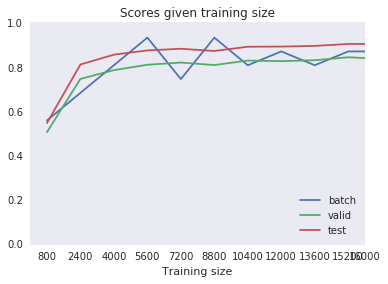

In [6]:
# Version with Conv > ReLU > MaxPool > Conv > ReLU > MaxPool > FullyConnected > ReLU > FullyConnected

batch_size = 16
#batch_size = 4
patch_size = 5
depth = 16
num_hidden = 64
#num_hidden = 8

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    # Model.
    def model(data):
        # Conv > ReLU > MaxPool
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        hidden = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

        # Conv > ReLU > MaxPool
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        hidden = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

        # Reshape cube to line
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])

        # Fully Connected > ReLU
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases

    # Training computation.
    logits = model(tf_train_dataset)
    #with tf.name_scope('accuracy'):
        #tf.scalar_summary('logitsej', logits) # TensorBOARD
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))



# To visualize generated data in TensorBoard :
# 1/ In a (tensorflow env)-terminal run : tensorboard --logdir=//home/christophe/data/tensorboard
# 2/ Browse to : http://localhost:6006

num_steps = 1001

data = np.ndarray(shape=(1+num_steps//100,4), dtype=np.float32)

with tf.Session(graph=graph) as session:

    #merged = tf.merge_all_summaries() # TensorBOARD
    #train_writer = tf.train.SummaryWriter('/home/christophe/data/tensorboard', session.graph) # TensorBOARD

    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            #session.run([merged], feed_dict=feed_dict(False))
            #session.run([merged])
            batch_score = accuracy(predictions, batch_labels)
            valid_score = accuracy(valid_prediction.eval(), valid_labels)
            test_score = accuracy(test_prediction.eval(), test_labels)
            data[step//100,:] = [step*batch_size, batch_score/100, valid_score/100, test_score/100]
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % batch_score)
            print("Validation accuracy: %.1f%%" % valid_score)
    print("Test accuracy: %.1f%%" % test_score)

fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1:4])
ax.set_title('Scores given training size')
ax.legend(('batch','valid', 'test'), loc='lower right')
ax.set_xticks(data[:,0])
ax.set_xlabel('Training size')
ax.set_ylim(0,1.01)
ax.grid()

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

Initialized
Minibatch loss at step 0: 5.398189
Minibatch accuracy: 8.6%
Validation accuracy: 10.1%
Minibatch loss at step 50: 2.240440
Minibatch accuracy: 18.8%
Validation accuracy: 16.7%
Minibatch loss at step 100: 1.439758
Minibatch accuracy: 49.2%
Validation accuracy: 48.4%
Minibatch loss at step 150: 1.043277
Minibatch accuracy: 60.9%
Validation accuracy: 62.3%
Minibatch loss at step 200: 1.130346
Minibatch accuracy: 61.7%
Validation accuracy: 68.9%
Minibatch loss at step 250: 0.935889
Minibatch accuracy: 71.1%
Validation accuracy: 73.1%
Minibatch loss at step 300: 0.749421
Minibatch accuracy: 76.6%
Validation accuracy: 75.4%
Minibatch loss at step 350: 0.517108
Minibatch accuracy: 84.4%
Validation accuracy: 77.5%
Minibatch loss at step 400: 0.612629
Minibatch accuracy: 79.7%
Validation accuracy: 77.6%
Minibatch loss at step 450: 0.591039
Minibatch accuracy: 76.6%
Validation accuracy: 78.8%
Minibatch loss at step 500: 0.892401
Minibatch accuracy: 75.0%
Validation accuracy: 78.9%
Mi

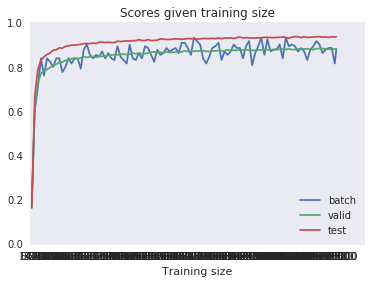

In [5]:
# *************************************************
# *************** Optimized version ***************
# *************************************************

batch_size = 128
patch_size = 5
depth1 = 16
depth2 = 32
num_hidden = 64
keep_prob = 0.7 # drop out prob

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth1]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
    layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth2, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    # Model.
    def model(data):
        # Conv > ReLU > MaxPool
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        hidden = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

        # Conv > ReLU > MaxPool
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        hidden = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

        # Drop Out
        hidden = tf.nn.dropout(hidden, keep_prob)

        # Reshape cube to line
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])

        # Fully Connected > ReLU
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)

        # Drop Out
        hidden = tf.nn.dropout(hidden, keep_prob)

        return tf.matmul(hidden, layer4_weights) + layer4_biases

    # Training computation.
    logits = model(tf_train_dataset)
    #with tf.name_scope('accuracy'):
        #tf.scalar_summary('logitsej', logits) # TensorBOARD
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer with learning rate decay
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.1
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 100000, 0.96, staircase=True)
    # Passing global_step to minimize() will increment it at each step.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
#    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))



# To visualize generated data in TensorBoard :
# 1/ In a (tensorflow env)-terminal run : tensorboard --logdir=//home/christophe/data/tensorboard
# 2/ Browse to : http://localhost:6006

num_steps = 10001

data = np.ndarray(shape=(1+num_steps//100,4), dtype=np.float32)

with tf.Session(graph=graph) as session:

    #merged = tf.merge_all_summaries() # TensorBOARD
    #train_writer = tf.train.SummaryWriter('/home/christophe/data/tensorboard', session.graph) # TensorBOARD

    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            #session.run([merged], feed_dict=feed_dict(False))
            #session.run([merged])
            batch_score = accuracy(predictions, batch_labels)
            valid_score = accuracy(valid_prediction.eval(), valid_labels)
            test_score = accuracy(test_prediction.eval(), test_labels)
            data[step//100,:] = [step*batch_size, batch_score/100, valid_score/100, test_score/100]
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % batch_score)
            print("Validation accuracy: %.1f%%" % valid_score)
    print("Test accuracy: %.1f%%" % test_score)

fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1:4])
ax.set_title('Scores given training size')
ax.legend(('batch','valid', 'test'), loc='lower right')
ax.set_xticks(data[:,0])
ax.set_xlabel('Training size')
ax.set_ylim(0,1.01)
ax.grid()